# Analyzing CIA Factbook Data Using SQLite and Python

in this project we are going to analyse CIA factbook which is about statistics for all of the countries on Earth there are some questions that we are going to answer:

general statistics

the most common birth rate, death rate and population for countries

which countries have high density 

which country have high water to land ratio

we are going to use SQLite and Python

first we  connect  to database and get some information about the tables in database

In [4]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("factbook.db")

q= "SELECT * FROM sqlite_master WHERE type='table';"
pd.read_sql_query(q, conn)

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY..."


lets just explore 5 rows of facts table as you can see in blow

In [8]:
q = "select * from facts limit 5"

pd.read_sql_query(q, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
1,2,al,Albania,28748,27398,1350,3029278,0.30,12.92,6.58,3.30
2,3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
3,4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.00
4,5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


## Summary statistics

lets calculate some summery statistics about this table to see anything interesting

In [10]:
q ="select min(population), max(population), min(population_growth), max(population_growth) from facts"
pd.read_sql_query(q, conn)

,min(population),max(population),min(population_growth),max(population_growth)
0,0,7256490011,0.0,4.02


as you can see the results in above indicate that there is a row with 0 population and a row with more than 7.2 billion. lets find out about theses rows first start with 7.2 billion

In [14]:
q = " select * from facts where population == (select max(population) from facts)"
pd.read_sql_query(q, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,261,xx,World,None,None,None,7256490011,1.08,18.6,7.8,None


the name of country for this row is world and the population actually indicate the population of whole world.


In [15]:
q = " select * from facts where population == (select min(population) from facts)"
pd.read_sql_query(q, conn)

,id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
0,250,ay,Antarctica,None,280000,None,0,None,None,None,None


Also the zero population is belong to Antarctica which seems to be logical

## Histograms for  population, population_growth, birth_rate, death_rate

in this section we are going to only select  `population`, `population_growth`, `birth_rate`, `death_rate` columns form database to plot histogram for each column

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f507f9ae668>,
      dtype=object)

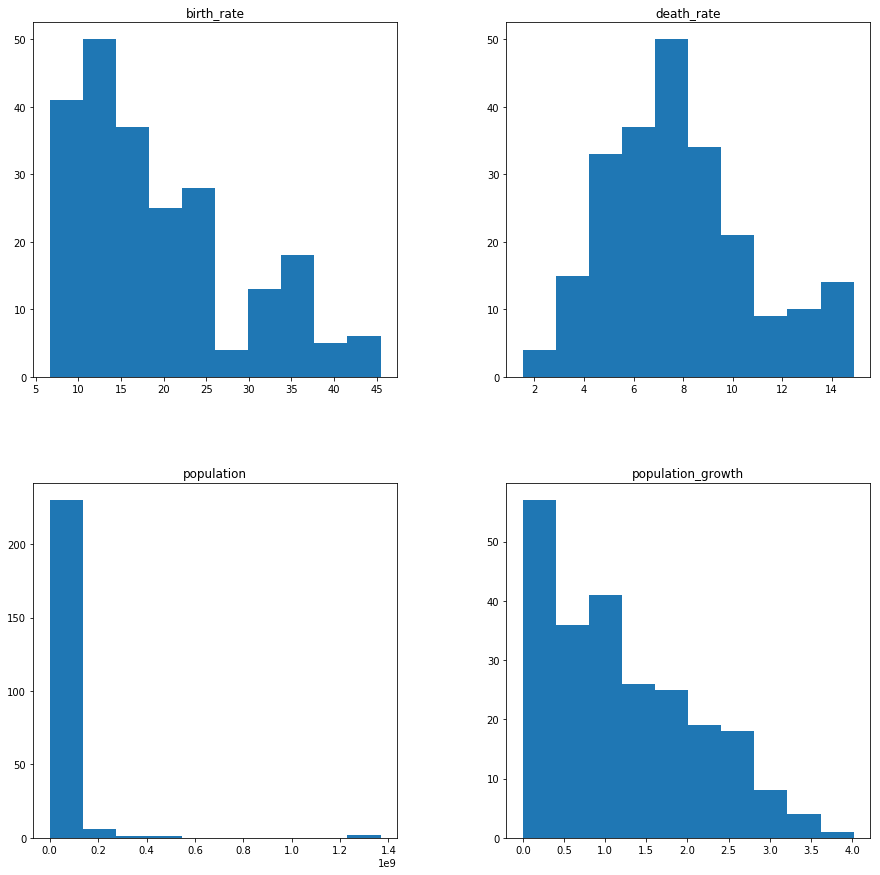

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(2, 2, 1)

q = '''select population, population_growth, birth_rate, death_rate from facts
where (population != (select min(population) from facts)) and (population != (select max(population) from facts))
'''


pd.read_sql_query(q, conn).hist(ax = ax1, grid = False)


as we can see in histograms above most of rows have birth rate between 7 and 25 percent and actually there is no country with less than 7% birth rate. for the death rate most of rows have the rate between 5 and 9 %. for the population column. there are very few rows with population between 1.2 and 1.4 billion which obviously are china and India and there are no countries with population between 600 million and 1.2 billion there is a big gap here most of countries have around 100 million population between zero and 100 million.

## highest population density

Population density is the ratio of population to land area lets calculate this factor for our data set


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f507f37b908>]],
      dtype=object)

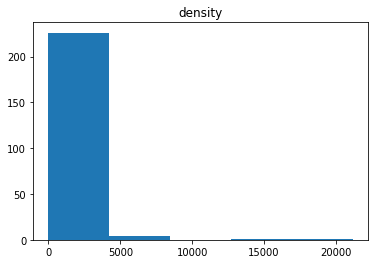

In [38]:
q = ''' select cast(population as float) / cast(area_land as float) as density from facts
where (population != (select min(population) from facts)) and (population != (select max(population) from facts))
order by density desc'''

pd.read_sql_query(q, conn).hist(grid = False, bins = 5)


most of countries have the density less than 5000. lets find 20 top countries in case of density

In [36]:
q = ''' select name, cast(population as float) / cast(area_land as float) as density from facts
where (population != (select min(population) from facts)) and (population != (select max(population) from facts))
order by density desc
limit 20
'''

pd.read_sql_query(q, conn)

,name,density
0,Macau,21168.964286
1,Monaco,15267.500000
2,Singapore,8259.784571
3,Hong Kong,6655.271202
4,Gaza Strip,5191.819444
5,Gibraltar,4876.333333
6,Bahrain,1771.859211
7,Maldives,1319.640940
8,Malta,1310.015823
9,Bermuda,1299.925926


you can see in the table the top 20 high density countries with their name and density value

## Water to land ration

we are going to calculate ware to land ration for each country by  dividing `area_land` from 'area_water' column as in code blow

In [46]:
q = ''' select name, cast(area_water as float) / cast(area_land as float) as water_to_land from facts
where (population != (select min(population) from facts)) and (population != (select max(population) from facts))
order by water_to_land desc
limit 20
'''

pd.read_sql_query(q, conn)

,name,water_to_land
0,Virgin Islands,4.520231
1,Puerto Rico,0.554791
2,"Bahamas, The",0.386613
3,Guinea-Bissau,0.284673
4,Malawi,0.259396
5,Netherlands,0.225710
6,Uganda,0.222922
7,Eritrea,0.164356
8,Liberia,0.156240
9,Bangladesh,0.140509


we can see the result for top 20 in the table above Virgin Islands	 is the only country in the world which has more water than land because the ratio value for this country is greater than 1

## Conclusion

we analyzed CIA fact book 

-most countries have birth rate between 7 and 25 percent
 
-most countries have death rate between 5 and 9 %
 
-most countries have population between zero and 100 million.
 
-most countries have the density less than 5000.
 
-Macau is the country with the highest density 21168.96

 Virgin Islands	 are the only country in the world which has more water than land
 